In [146]:
# librerías a utilizar
import numpy as np 
import pandas as pd
import datetime as datetime

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [147]:
# cargamos los datos
events = pd.read_csv('events.csv', low_memory = False)
events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
# formateo la fecha y agrego campos por día/mes/año
events['timestamp'] = pd.to_datetime(events['timestamp'], errors = 'coerce', format= '%Y-%m-%d')
events['timestamp_month'] = events['timestamp'].dt.month
events['timestamp_year'] = events['timestamp'].dt.year
events['timestamp_weekday'] = events['timestamp'].dt.weekday_name
events['timestamp_day'] = events['timestamp'].dt.day
events[['timestamp_month', 'timestamp_year', 'timestamp_weekday']].head()

,timestamp_month,timestamp_year,timestamp_weekday
0,5,2018,Thursday
1,5,2018,Thursday
2,5,2018,Thursday
3,5,2018,Thursday
4,5,2018,Tuesday


In [159]:
visited_events = events[events['event'] == 'visited site']
# creo que estos son los eventos asociados a las marcas (validar que no falte alguno)
viewed_events = events[events['event'] == 'viewed product']
leaded_events = events[events['event'] == 'lead']
conversion_events = events[events['event'] == 'conversion']
checkouted_events = events[events['event'] == 'checkout']
# agrego columnas marca y modelo
events['marca'] = events['model'].str.split(' ').str[0]
events['modelo'] = events['model'].str.split(' ').str[1].fillna('') + ' ' + events['model'].str.split(' ').str[2].fillna('')

In [150]:
# cuales son las campañas más exitosas
campaigns_sources = events[events['event'] == 'ad campaign hit'].groupby('campaign_source').agg({'event':'count'}).reset_index()
campaigns_sources = campaigns_sources.sort_values(by='event', ascending = False)
campaigns_sources.head()

,campaign_source,event
13,google,58153
10,criteo,9694
19,rtbhouse,8550
23,zanox,1673
12,emblue,1352


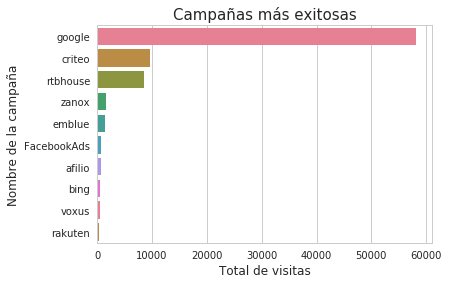

In [151]:
g = sns.barplot(x=campaigns_sources.event, y=campaigns_sources.campaign_source[:10], palette=sns.color_palette("husl", 8))
g.set_title("Campañas más exitosas", fontsize=15)
g.set_xlabel("Total de visitas", fontsize=12)
g.set_ylabel("Nombre de la campaña", fontsize=12);

In [152]:
events['ads_accion'] = events['url'].str.split('/').str[1]
events['ads_marca'] = events['url'].str.split('/').str[2]
events['ads_modelo'] = events['url'].str.split('/').str[3]
ads_event = events[(events['event'] == 'ad campaign hit') & (events['url'] != '/')]
ads_event[['timestamp', 'person', 'url', 'ads_accion', 'ads_marca', 'ads_modelo']].head()

,timestamp,person,url,ads_accion,ads_marca,ads_modelo
0,2018-05-31 23:38:05,0004b0a2,/comprar/iphone/iphone-5s,comprar,iphone,iphone-5s
6,2018-05-29 13:29:27,0006a21a,/comprar/samsung/galaxy-s8,comprar,samsung,galaxy-s8
99,2018-05-17 00:08:56,0019c395,/comprar/samsung/galaxy-j5,comprar,samsung,galaxy-j5
101,2018-05-17 00:11:10,0019c395,/comprar/samsung/galaxy-j5,comprar,samsung,galaxy-j5
107,2018-06-08 12:15:33,001bb7eb,/comprar/iphone/6,comprar,iphone,6


In [153]:
# hay pocos ads sobre vender. tal vez se debería fomentar más eso
events['ads_accion'].value_counts()

comprar               54209
                      28323
vender                  221
clube-trocafone           2
termos-e-condicoes        1
Name: ads_accion, dtype: int64

In [154]:
# hay mucha propaganda sobre samsung y iphone
# se corresponde con los productos más comprados
ads_event[ads_event['ads_accion'] == 'comprar']['ads_marca'].value_counts()

samsung     26485
iphone      20109
motorola     5594
lg            972
sony          484
asus          222
lenovo        187
ipad          121
quantum        10
ofertas        10
apple           8
list            7
Name: ads_marca, dtype: int64

In [177]:
# marca de la campaña vs marca comprada
# ver que graficar
persons_advertised = ads_event[ads_event['ads_accion'] == 'comprar'][['person', 'timestamp', 'ads_marca']]
a = conversion_events[['person', 'timestamp', 'marca']]
merge = pd.merge(persons_advertised, a, on='person', how='left')
compras = merge[merge['timestamp_y'] > merge['timestamp_x']]
compras.drop_duplicates(subset=['person','timestamp_y']).head()


,person,timestamp_x,ads_marca,timestamp_y,marca
6,00204059,2018-02-01 23:32:02,iphone,2018-03-20 17:46:12,Motorola
158,00c13dee,2018-03-18 01:48:39,iphone,2018-04-26 22:28:53,Samsung
212,0146a9df,2018-03-16 13:39:15,iphone,2018-03-16 13:50:25,iPhone
321,01db2fe6,2018-02-09 20:29:56,samsung,2018-02-09 22:07:07,Samsung
997,04fbc241,2018-01-10 18:41:20,samsung,2018-01-10 18:59:05,Samsung


In [185]:
persons_advertised['compro'] = persons_advertised['person'].isin(conversion_events['person'].values)
persons_advertised.groupby('compro').agg()

,person,timestamp,ads_marca
compro,,,
False,48614,48614,48614
True,5595,5595,5595
